In [1]:
!pip install tensorflow
# Если вам не повезло и tensorflow последней версии не устанавливается или не хочет работать, то надо поставить версию 1.5
# !pip install tensorflow==1.5

In [2]:
# подключение библиотек
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp

%matplotlib inline

In [3]:
import pandas as pd

data = pd.read_csv('titanic_train.csv', index_col='PassengerId')
print(f'Всего данных: {data.shape[0]}')
data.head()

Всего данных: 891


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Пишем наши собственные препроцессоры
# Обратите внивание тут добавлено несколько новых препроцессоров (в сравнение с 4 работой)
import sklearn.pipeline as pipeline
import sklearn.preprocessing as preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from keras.utils import to_categorical

class FillNa(TransformerMixin, BaseEstimator):
    """
    Удаление пропусков в данных
    """
    
    def fit(self, X: pd.DataFrame, y=None):
        return self
    
    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        """
        Убираем пропуски в данных
        """
        return X.interpolate(method='cubic').fillna(method='pad').dropna()
        
    
    
class DropOutlet(TransformerMixin, BaseEstimator):
    """
    Удаление выбросов, основываясь на правиле 3-х сигм (только для нормального распределения)
    """
        
    def fit(self, X: pd.DataFrame, y=None):
        """
        Получаем стандартное отклонение для каждого столбца и сохраняем их        
        """
        self.std = X.std()
        self.columns = self.std.index.values
        return self
    
    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        """
        Убираем все здачения, котоые находятся дальше 3-х стандартных отконений (сигма) от мат. ожидания случайной величины
        """
        X_cols = X[self.columns]
        return X[ (X_cols - X_cols.mean()).abs() <= 3*self.std ].dropna()

class PandasToNumpy(BaseEstimator):
    """
    Просто преобразует данные из DataFrame от pandas к матрице от numpy (ndarray)
    """
    
    def fit(self, X : pd.DataFrame = None, y=None):
        return self
    
    def transform(self, X: pd.DataFrame, y=None) -> np.ndarray:
        return X.values
    
class SparseToArray(TransformerMixin, BaseEstimator):
    """
    Класс преобразует sparse matrix в ndarray
    """
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.toarray()

class ModifyLabelEncoder(preprocessing.LabelEncoder):
    """
    Стандартный костыль для препроцессора LabelEncoder
    """
    
    def fit(self, X, y=None):
        return super().fit(X)
    
    def transform(self, X, y=None):
        print(1)
        return super().transform(X)
    
    def fit_transform(self, X, y=None):
        return super().fit_transform(X)
    
    
class ExpandDims(TransformerMixin, BaseEstimator):
    """
    Увеличение на 1 рамерности массима в нужной оси
    """
    
    def __init__(self, axis):
        self.axis = axis
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.expand_dims(X, axis=self.axis)

C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [9]:
# Создадим наш pipeline
# drop_outlet, to_matrix, norm - это просто названия препроцессоров данное пользователем
# выбираем данные для обучающей выборки (то что будет подано на вход алгоритмам машинного обучения)
X_data = data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']].copy()
# Кодируем все классы в виде единичных векторов
X_data = pd.get_dummies(X_data)

# выбираем данные для обучающей выборки (то что будет на выходу алгоритмов машинного обучения)
Y_data = data[['Survived']].copy()

# Создаем препроцессор для заполнения пропусков
fill_na_pipe = pipeline.Pipeline([
    ('fill', FillNa()),
])

# Убираем вылеты из данных
pipe_outlet = pipeline.Pipeline([
    ('fill_na', fill_na_pipe),
    ('drop_outlet', DropOutlet()),
])

outletless_data_X = pipe_outlet.fit_transform(X_data)

# Соглачуем два массива X и Y
# Записи которые были удалены из массива X должны быть удалены и из массива Y
# Для удаления записей мы берем индексы из массива X и оставляем записи в массиве Y с индексами, которые есть в X
outletless_data_Y = Y_data[ fill_na_pipe.fit_transform(Y_data).index.isin(outletless_data_X.index) ]

# Нормализуем данные X
pipe_x = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('norm', preprocessing.MinMaxScaler())
])

# Нормализуем данные Y
pipe_y = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('label_encoder', ModifyLabelEncoder()),
    ('expand_dims', ExpandDims(axis=1)),
    ('one_hot_encoder', preprocessing.OneHotEncoder(sparse=False))
])

# вызываем препроцессоры
number_data_ready_X = pipe_x.fit_transform(outletless_data_X)
number_data_ready_Y = pipe_y.fit_transform(outletless_data_Y)

print(number_data_ready_X.shape, number_data_ready_Y.shape)

(821, 7) (821, 2)


C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [10]:
number_data_ready_X[:10,:], number_data_ready_Y[::10]

(array([[1.        , 0.37002318, 0.33333333, 0.        , 0.04397492,
         0.        , 1.        ],
        [0.        , 0.5638622 , 0.33333333, 0.        , 0.4323693 ,
         1.        , 0.        ],
        [1.        , 0.41848293, 0.        , 0.        , 0.04806914,
         1.        , 0.        ],
        [0.        , 0.52751738, 0.33333333, 0.        , 0.32207838,
         1.        , 0.        ],
        [1.        , 0.52751738, 0.        , 0.        , 0.04882733,
         0.        , 1.        ],
        [1.        , 0.80908601, 0.        , 0.        , 0.05130387,
         0.        , 1.        ],
        [0.        , 0.75770122, 0.        , 0.        , 0.31457232,
         0.        , 1.        ],
        [1.        , 0.1277244 , 1.        , 0.5       , 0.12783054,
         0.        , 1.        ],
        [1.        , 0.43059787, 0.        , 1.        , 0.0675291 ,
         1.        , 0.        ],
        [0.5       , 0.27310367, 0.33333333, 0.        , 0.18239463,
    

### 3. Построение простой нейронной сети

In [12]:
X_train = number_data_ready_X
Y_train = number_data_ready_Y
X_train.shape, Y_train.shape

((821, 7), (821, 2))

In [13]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras import activations
from keras.optimizers import Adam, RMSprop
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy

In [14]:
model = Sequential()
model.add(Dense(10, activation=activations.relu, input_dim=X_train.shape[1])) # input_dim = 4
model.add(Dense(Y_train.shape[1], activation=activations.softmax)) # output = 3

model.compile(Adam(), categorical_crossentropy, metrics=[categorical_accuracy])

### 4. Обучение

In [15]:
model.fit(X_train, Y_train, verbose=2, epochs=100, batch_size=3)

Epoch 1/100
 - 1s - loss: 0.6426 - categorical_accuracy: 0.6516
Epoch 2/100
 - 0s - loss: 0.5508 - categorical_accuracy: 0.7929
Epoch 3/100
 - 0s - loss: 0.4973 - categorical_accuracy: 0.7929
Epoch 4/100
 - 0s - loss: 0.4772 - categorical_accuracy: 0.7942
Epoch 5/100
 - 0s - loss: 0.4682 - categorical_accuracy: 0.7929
Epoch 6/100
 - 0s - loss: 0.4633 - categorical_accuracy: 0.7929
Epoch 7/100
 - 0s - loss: 0.4597 - categorical_accuracy: 0.7966
Epoch 8/100
 - 0s - loss: 0.4577 - categorical_accuracy: 0.7990
Epoch 9/100
 - 0s - loss: 0.4558 - categorical_accuracy: 0.7954
Epoch 10/100
 - 0s - loss: 0.4535 - categorical_accuracy: 0.7990
Epoch 11/100
 - 0s - loss: 0.4521 - categorical_accuracy: 0.7966
Epoch 12/100
 - 0s - loss: 0.4511 - categorical_accuracy: 0.7978
Epoch 13/100
 - 0s - loss: 0.4506 - categorical_accuracy: 0.7990
Epoch 14/100
 - 0s - loss: 0.4485 - categorical_accuracy: 0.8002
Epoch 15/100
 - 0s - loss: 0.4483 - categorical_accuracy: 0.7990
Epoch 16/100
 - 0s - loss: 0.4470 

In [16]:
model.evaluate(X_train, Y_train)

821/821 [==============================] - 0s 51us/step


[0.41440965407658437, 0.8221680879157295]

### 5. Построение усложненого варианта НС с делением данных на обучающую и тестовую выборку с визуализацие процесса обучения

In [17]:
# Подключим новые библиотеки
# библиотека дополнительных возможностей (действий) при обучении сети
from keras import callbacks

In [18]:
# Делим
# Делить будем в отношении 80/20
# 80 - это обучение
# 20 - тест
# первым делом перемешаем выборку (надо для того что бы обе выборки были репрезентативными)
XY_data = np.hstack( (number_data_ready_X, number_data_ready_Y) ).transpose((0,1))
np.random.shuffle(XY_data)
# Делим выборки
point_split = round(XY_data.shape[0] * 0.8)
train_data = XY_data[:point_split]
test_data = XY_data[point_split:]
print(f'Всего данных: {XY_data.shape[0]}')
print(f'Тренировочных данных: {train_data.shape[0]}')
print(f'Тестовых данных: {test_data.shape[0]}')
# Делим все на входные и выходные данные
# Тренировочные
X_train = train_data[:, :number_data_ready_X.shape[1] ]
Y_train = train_data[:, :number_data_ready_Y.shape[1] ]
print(f'Размер данные для тренировки (входных): {X_train.shape}')
print(f'Размер данные для тренировки (выходных): {Y_train.shape}')

# Тестовые
X_test = test_data[:, :number_data_ready_X.shape[1] ]
Y_test = test_data[:, :number_data_ready_Y.shape[1] ]
print(f'Размер данные для теста (входных): {X_test.shape}')
print(f'Размер данные для теста (выходных): {Y_test.shape}')

Всего данных: 821
Тренировочных данных: 657
Тестовых данных: 164
Размер данные для тренировки (входных): (657, 7)
Размер данные для тренировки (выходных): (657, 2)
Размер данные для теста (входных): (164, 7)
Размер данные для теста (выходных): (164, 2)


In [19]:
def make_nn(input_len, output_len):
    model = Sequential()
    model.add(Dense(10, activation=activations.relu, input_dim=input_len))
    model.add(Dense(output_len, activation=activations.softmax))
    model.compile(Adam(), categorical_crossentropy, metrics=[categorical_accuracy])
    return model

In [22]:
model = make_nn(X_train.shape[1], Y_train.shape[1])

print('Начинаем обучение сети')
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=20,
    epochs=50,
    verbose=1,
    validation_data=(X_test, Y_test),
    callbacks=[
        callbacks.History(),
    ]
    
)

Начинаем обучение сети
Train on 657 samples, validate on 164 samples
Epoch 1/50
657/657 [==============================] - 0s 516us/step - loss: 0.7013 - categorical_accuracy: 0.8569 - val_loss: 0.6665 - val_categorical_accuracy: 0.8720
Epoch 2/50
657/657 [==============================] - 0s 67us/step - loss: 0.6820 - categorical_accuracy: 0.9041 - val_loss: 0.6557 - val_categorical_accuracy: 0.8963
Epoch 3/50
657/657 [==============================] - 0s 78us/step - loss: 0.6704 - categorical_accuracy: 0.9117 - val_loss: 0.6457 - val_categorical_accuracy: 0.9024
Epoch 4/50
657/657 [==============================] - 0s 68us/step - loss: 0.6601 - categorical_accuracy: 0.9163 - val_loss: 0.6376 - val_categorical_accuracy: 0.8780
Epoch 5/50
657/657 [==============================] - 0s 81us/step - loss: 0.6517 - categorical_accuracy: 0.9132 - val_loss: 0.6316 - val_categorical_accuracy: 0.8720
Epoch 6/50
657/657 [==============================] - 0s 70us/step - loss: 0.6454 - categorical

657/657 [==============================] - 0s 59us/step - loss: 0.6155 - categorical_accuracy: 0.9619 - val_loss: 0.6015 - val_categorical_accuracy: 0.9817
Epoch 50/50
657/657 [==============================] - 0s 61us/step - loss: 0.6154 - categorical_accuracy: 0.9696 - val_loss: 0.6013 - val_categorical_accuracy: 0.9878


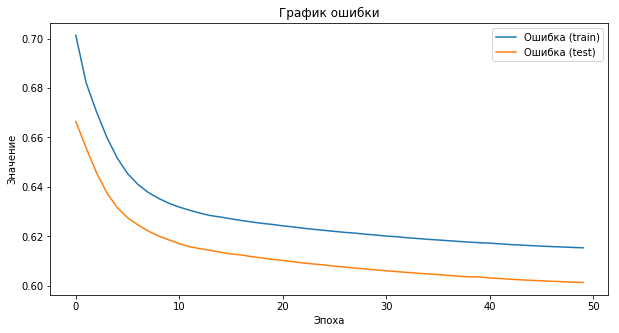

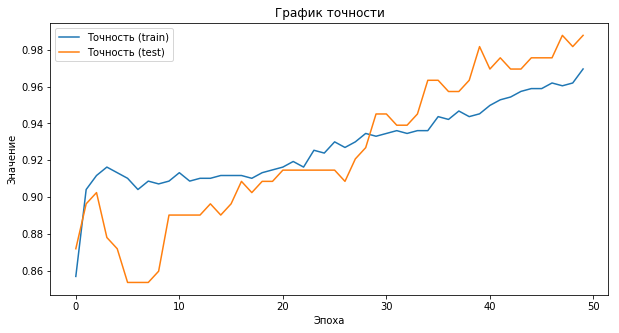

In [23]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);

In [26]:
model = make_nn(number_data_ready_X.shape[1], number_data_ready_Y.shape[1])

print('Начинаем обучение сети')
history = model.fit(
    x=number_data_ready_X,
    y=number_data_ready_Y,
    batch_size=10,
    epochs=50,
    verbose=1,
#     Вот это разделения данных в соотношении 80/20
    validation_split=0.2,
    callbacks=[
        callbacks.History(),
    ]
    
)

Начинаем обучение сети
Train on 656 samples, validate on 165 samples
Epoch 1/50
656/656 [==============================] - 0s 678us/step - loss: 0.6852 - categorical_accuracy: 0.5412 - val_loss: 0.6204 - val_categorical_accuracy: 0.7273
Epoch 2/50
656/656 [==============================] - 0s 134us/step - loss: 0.5940 - categorical_accuracy: 0.7424 - val_loss: 0.5568 - val_categorical_accuracy: 0.7758
Epoch 3/50
656/656 [==============================] - 0s 133us/step - loss: 0.5517 - categorical_accuracy: 0.7652 - val_loss: 0.5196 - val_categorical_accuracy: 0.8061
Epoch 4/50
656/656 [==============================] - 0s 134us/step - loss: 0.5256 - categorical_accuracy: 0.7774 - val_loss: 0.4962 - val_categorical_accuracy: 0.8242
Epoch 5/50
656/656 [==============================] - 0s 134us/step - loss: 0.5084 - categorical_accuracy: 0.7820 - val_loss: 0.4815 - val_categorical_accuracy: 0.8182
Epoch 6/50
656/656 [==============================] - 0s 120us/step - loss: 0.4979 - catego

656/656 [==============================] - 0s 119us/step - loss: 0.4468 - categorical_accuracy: 0.7942 - val_loss: 0.3967 - val_categorical_accuracy: 0.8242
Epoch 49/50
656/656 [==============================] - 0s 113us/step - loss: 0.4474 - categorical_accuracy: 0.7973 - val_loss: 0.3964 - val_categorical_accuracy: 0.8242
Epoch 50/50
656/656 [==============================] - 0s 117us/step - loss: 0.4466 - categorical_accuracy: 0.7957 - val_loss: 0.3964 - val_categorical_accuracy: 0.8242


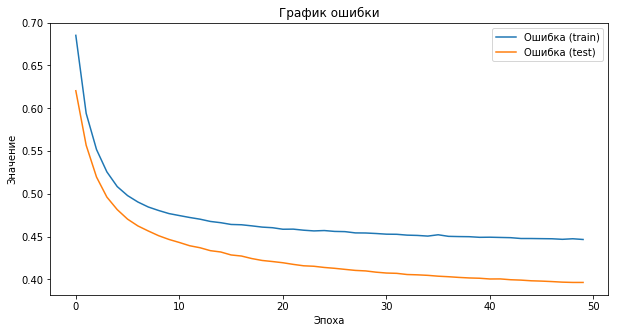

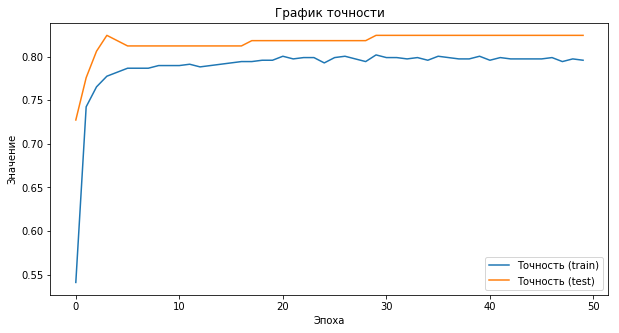

In [27]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);

In [28]:
model = make_nn(number_data_ready_X.shape[1], number_data_ready_Y.shape[1])

print('Начинаем обучение сети')
history = model.fit(
    x=number_data_ready_X,
    y=number_data_ready_Y,
    batch_size=3,
#     Так как у нас теперь есть рання остановка мы можем увеличеть количество эпох (было 100 стало 300)
    epochs=300,
    verbose=1,
#     Вот это разделения данных в соотношении 80/20
    validation_split=0.2,
    callbacks=[
        callbacks.History(),
        callbacks.EarlyStopping(
#             На основе какого значения будет приниматься решеня об остановке
            monitor='val_categorical_accuracy',
#             Указываем направления лучшего значения (min, max, auto) лучшим является если тестовая точноть будет максимальной
            mode='max',
#             Количество эпок в резельтате которых если значение не изменилось, то произвести остановку
            patience=50,
#             "Чуствительность" метода - изменения ниже данного значения дубут считатья 0 (изменения в отслеживаемом значении нету)
            min_delta=0.01,
        )
    ]
    
)

Начинаем обучение сети
Train on 656 samples, validate on 165 samples
Epoch 1/300
656/656 [==============================] - 1s 1ms/step - loss: 0.6757 - categorical_accuracy: 0.6082 - val_loss: 0.5539 - val_categorical_accuracy: 0.8000
Epoch 2/300
656/656 [==============================] - 0s 430us/step - loss: 0.5366 - categorical_accuracy: 0.7866 - val_loss: 0.4776 - val_categorical_accuracy: 0.8121
Epoch 3/300
656/656 [==============================] - 0s 419us/step - loss: 0.4984 - categorical_accuracy: 0.7881 - val_loss: 0.4478 - val_categorical_accuracy: 0.8121
Epoch 4/300
656/656 [==============================] - 0s 418us/step - loss: 0.4850 - categorical_accuracy: 0.7896 - val_loss: 0.4423 - val_categorical_accuracy: 0.8121
Epoch 5/300
656/656 [==============================] - 0s 398us/step - loss: 0.4803 - categorical_accuracy: 0.7896 - val_loss: 0.4367 - val_categorical_accuracy: 0.8182
Epoch 6/300
656/656 [==============================] - 0s 483us/step - loss: 0.4752 - ca

Epoch 49/300
656/656 [==============================] - 0s 415us/step - loss: 0.4458 - categorical_accuracy: 0.7957 - val_loss: 0.4040 - val_categorical_accuracy: 0.8182
Epoch 50/300
656/656 [==============================] - 0s 412us/step - loss: 0.4470 - categorical_accuracy: 0.7912 - val_loss: 0.4010 - val_categorical_accuracy: 0.8182
Epoch 51/300
656/656 [==============================] - 0s 381us/step - loss: 0.4451 - categorical_accuracy: 0.8003 - val_loss: 0.4030 - val_categorical_accuracy: 0.8182
Epoch 52/300
656/656 [==============================] - 0s 412us/step - loss: 0.4443 - categorical_accuracy: 0.7881 - val_loss: 0.4001 - val_categorical_accuracy: 0.8303
Epoch 53/300
656/656 [==============================] - 0s 436us/step - loss: 0.4448 - categorical_accuracy: 0.7912 - val_loss: 0.3997 - val_categorical_accuracy: 0.8242
Epoch 54/300
656/656 [==============================] - 0s 479us/step - loss: 0.4445 - categorical_accuracy: 0.7896 - val_loss: 0.3989 - val_categoric

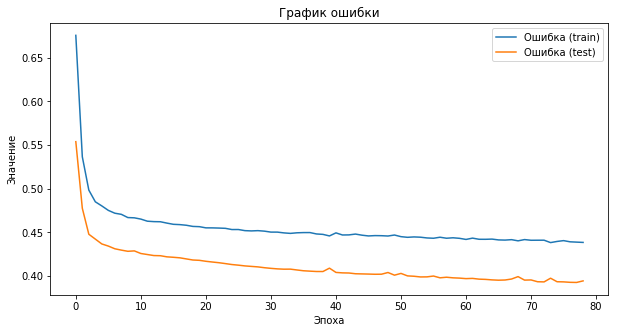

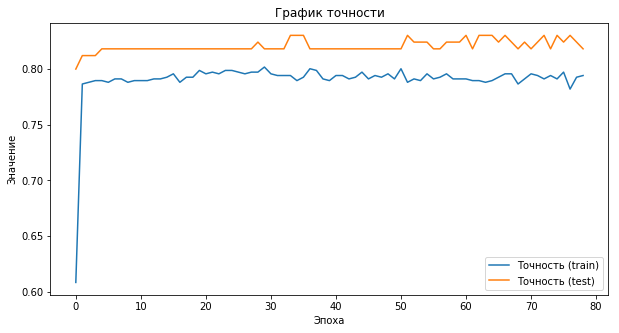

In [29]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);

### 6. Контрольные точки

In [30]:
from pathlib import Path
from os import remove

In [31]:
# создадим функцию создания о очисти каталога контрольных точек
# указываем шаблон имени фала контрольной точки
file_name = 'nn_model_loss-{loss:.2f}_val_loss-{val_loss:.2f}_acc-{categorical_accuracy:.2f}_val_acc-{val_categorical_accuracy:.2f}.hdf5'
def make_save_points(name='save_points', file_name=file_name):
#     выбираем катагол (подробнее https://docs.python.org/3.6/library/pathlib.html ) 
    checkpoints_dir = Path('./').joinpath('save_points')
    print(f'Текущий каталог с контрольными точками {checkpoints_dir.absolute()}')
    # Создаем каталог если его нету
    checkpoints_dir.mkdir(exist_ok=True)
    # Удаляем все из каталога
    for item in checkpoints_dir.iterdir():
        if item.is_file():
            print(f'Удаляем файл {item}')
            remove(item)
    return str(checkpoints_dir.joinpath(file_name))

In [32]:
print('Начинаем обучение сети')
history = make_nn(X_train.shape[1], Y_train.shape[1]).fit(
    x=X_train,
    y=Y_train,
    batch_size=3,
    epochs=300,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        callbacks.History(),
        # Добавляем сценарий ранней остановки
        # Если в течении 30 эпох точность не вырастить более чем на 1%, то произойдет остановка
        callbacks.EarlyStopping(
            monitor='val_categorical_accuracy',
            mode='max',
            patience=50,
            min_delta=0.01
        ),
#         Callback сохранений состояний сети
        callbacks.ModelCheckpoint(
#             Указываем путь для сохранения и формат имен файлов
            make_save_points(file_name=file_name),
#             Указываем какое значение отслеживать
            monitor='val_categorical_accuracy',
#             Указываем, что сохранять надо только лучшие результаты
            save_best_only=True,
#             Говорим как часто проверять, что текущий результат лучше предидущего (в эпохах)
            period=5,
#             Указываем сторону лучших значений
            mode='max'
        )
    ]
)

Начинаем обучение сети
Текущий каталог с контрольными точками C:\Users\User\save_points
Train on 525 samples, validate on 132 samples
Epoch 1/300
525/525 [==============================] - 1s 1ms/step - loss: 0.8405 - categorical_accuracy: 0.4819 - val_loss: 0.7393 - val_categorical_accuracy: 0.6970
Epoch 2/300
525/525 [==============================] - 0s 413us/step - loss: 0.7225 - categorical_accuracy: 0.8419 - val_loss: 0.7099 - val_categorical_accuracy: 0.8485
Epoch 3/300
525/525 [==============================] - 0s 467us/step - loss: 0.6906 - categorical_accuracy: 0.9200 - val_loss: 0.6836 - val_categorical_accuracy: 0.9167
Epoch 4/300
525/525 [==============================] - 0s 434us/step - loss: 0.6652 - categorical_accuracy: 0.9505 - val_loss: 0.6651 - val_categorical_accuracy: 0.8939
Epoch 5/300
525/525 [==============================] - 0s 404us/step - loss: 0.6478 - categorical_accuracy: 0.9219 - val_loss: 0.6519 - val_categorical_accuracy: 0.9015
Epoch 6/300
525/525 [==

525/525 [==============================] - 0s 415us/step - loss: 0.6125 - categorical_accuracy: 0.9829 - val_loss: 0.6226 - val_categorical_accuracy: 0.9394
Epoch 49/300
525/525 [==============================] - 0s 442us/step - loss: 0.6123 - categorical_accuracy: 0.9848 - val_loss: 0.6223 - val_categorical_accuracy: 0.9318
Epoch 50/300
525/525 [==============================] - 0s 383us/step - loss: 0.6122 - categorical_accuracy: 0.9790 - val_loss: 0.6218 - val_categorical_accuracy: 0.9318
Epoch 51/300
525/525 [==============================] - 0s 385us/step - loss: 0.6119 - categorical_accuracy: 0.9810 - val_loss: 0.6218 - val_categorical_accuracy: 0.9318
Epoch 52/300
525/525 [==============================] - 0s 408us/step - loss: 0.6120 - categorical_accuracy: 0.9829 - val_loss: 0.6221 - val_categorical_accuracy: 0.9242
Epoch 53/300
525/525 [==============================] - 0s 408us/step - loss: 0.6118 - categorical_accuracy: 0.9829 - val_loss: 0.6213 - val_categorical_accuracy: 

Epoch 96/300
525/525 [==============================] - 0s 417us/step - loss: 0.6104 - categorical_accuracy: 0.9790 - val_loss: 0.6200 - val_categorical_accuracy: 0.9318
Epoch 97/300
525/525 [==============================] - 0s 512us/step - loss: 0.6104 - categorical_accuracy: 0.9810 - val_loss: 0.6201 - val_categorical_accuracy: 0.9318
Epoch 98/300
525/525 [==============================] - 0s 436us/step - loss: 0.6104 - categorical_accuracy: 0.9771 - val_loss: 0.6199 - val_categorical_accuracy: 0.9318
Epoch 99/300
525/525 [==============================] - 0s 480us/step - loss: 0.6104 - categorical_accuracy: 0.9733 - val_loss: 0.6199 - val_categorical_accuracy: 0.9318
Epoch 100/300
525/525 [==============================] - 0s 413us/step - loss: 0.6103 - categorical_accuracy: 0.9790 - val_loss: 0.6200 - val_categorical_accuracy: 0.9318
Epoch 101/300
525/525 [==============================] - 0s 406us/step - loss: 0.6103 - categorical_accuracy: 0.9771 - val_loss: 0.6202 - val_categor

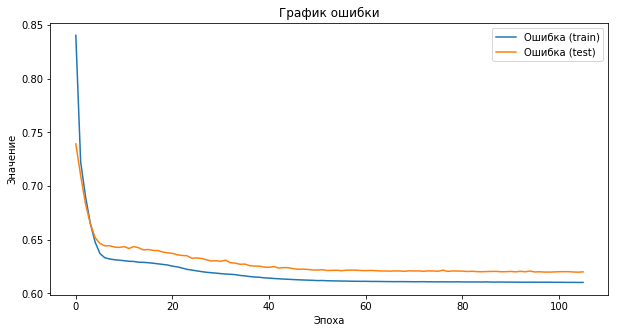

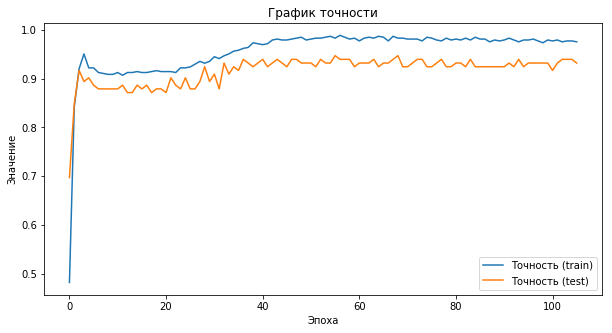

In [33]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);

In [41]:
from keras.models import load_model

# Загружаем контрольную точку (модель)
# Обратите внимание путь до контрольной точки может отличатся
loaded_model = load_model('./save_points/nn_model_loss-0.61_val_loss-0.62_acc-0.98_val_acc-0.94.hdf5')

# Прдсказываем класс
print(f'Точность предсказания на тренировочных данных {loaded_model.evaluate(X_train, Y_train)[1]}')
print(f'Точность предсказания на тестовых данных {loaded_model.evaluate(X_test, Y_test)[1]}')
predict = loaded_model.predict_classes(X_test)
predict

657/657 [==============================] - 0s 220us/step
Точность предсказания на тренировочных данных 0.9649923896499238
164/164 [==============================] - 0s 18us/step
Точность предсказания на тестовых данных 0.9512195121951219


array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1], dtype=int64)

In [42]:
# Преобразуем классы в виде числа в их оригеналы
pipe_y.named_steps['label_encoder'].inverse_transform(predict)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1], dtype=int64)

## Бонус - визуализация наших классов
Выполнять это не обязательно

In [43]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf(xx, yy)
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(821, 2)


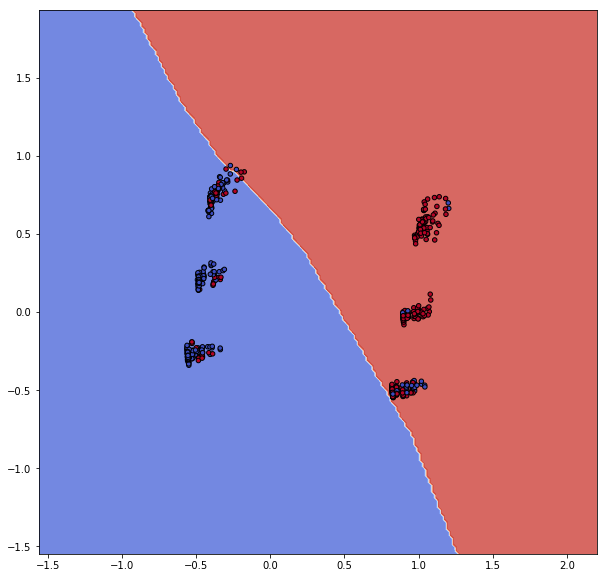

In [44]:
from sklearn.decomposition import PCA
pipe_y_mini = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('label_encoder', ModifyLabelEncoder()),
])


Y = pipe_y_mini.fit_transform(outletless_data_Y)
X = number_data_ready_X

pca = PCA(n_components=2)

_X = pca.fit_transform(X)
print(_X.shape)

clf_predict = lambda xx, yy: model.predict_classes(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))

X0, X1 = _X[:, 0], _X[:, 1]
xx, yy = make_meshgrid(X0, X1)

clf_predict(xx, yy)

fig, ax = plt.subplots(1,1, figsize=(10, 10))
plot_contours(ax, clf_predict, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=Y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')